In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import logging 
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt

from dagger.graph import DAG
from dagger.query import Query
from dagger.common import make_fake_df, normalise

logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s [%(filename)s:%(funcName)s:%(lineno)d] %(levelname)s - %(message)s',
)

2019-02-17 16:18:26,109 [pyplot.py:switch_backend:211] DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 1, 1, 1, 0], 
                   "c": [0, 0, 1, 0, 0, 1, 0, 1],
                   "d": [1, 1, 0, 1, 0, 0, 0, 0],
                   "e": [1, 1, 1, 1, 0, 0, 0, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("a", "c").add_edge("c", "b")

2019-02-17 16:18:26,125 [graph.py:add_edge:236] DEBUG - created connection a -> b
2019-02-17 16:18:26,126 [graph.py:add_edge:236] DEBUG - created connection a -> c
2019-02-17 16:18:26,126 [graph.py:add_edge:236] DEBUG - created connection c -> b


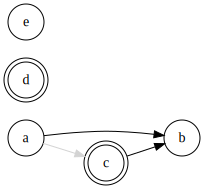

In [4]:
from graphviz import Digraph

def mkplot(dag, givens, dos):
    """A pretty plotting function."""
    d = Digraph()
    d.attr(rankdir='LR')
    d.attr('node', shape='circle')
    for n in dag.graph.nodes:
        if (n in givens) or (n in dos):
            d.node(n, shape='doublecircle')
        else:
            d.node(n)
    for n1, n2 in dag.graph.edges:
        if n2 in dos:
            d.edge(n1, n2, color="lightgray")
        else:
            d.edge(n1, n2)
    return d

mkplot(dag, givens=["d"], dos=["c"])

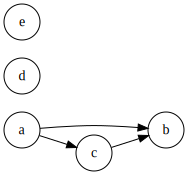

In [5]:
dag.plot()

2019-02-17 16:18:28,931 [graph.py:add_edge:236] DEBUG - created connection e -> a
2019-02-17 16:18:28,932 [graph.py:add_edge:236] DEBUG - created connection e -> d
2019-02-17 16:18:28,933 [graph.py:add_edge:236] DEBUG - created connection a -> d
2019-02-17 16:18:28,933 [graph.py:add_edge:236] DEBUG - created connection b -> d
2019-02-17 16:18:28,934 [graph.py:add_edge:236] DEBUG - created connection a -> b
2019-02-17 16:18:28,935 [graph.py:add_edge:236] DEBUG - created connection a -> c
2019-02-17 16:18:28,935 [graph.py:add_edge:236] DEBUG - created connection b -> c
2019-02-17 16:18:28,936 [graph.py:add_edge:236] DEBUG - created connection f -> c
2019-02-17 16:18:28,936 [graph.py:add_edge:236] DEBUG - created connection f -> g


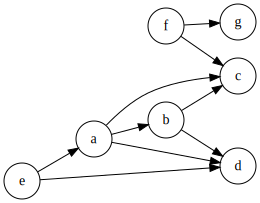

In [6]:
dag = (DAG(make_fake_df(7))
       .add_edge("e", "a")
       .add_edge("e", "d")
       .add_edge("a", "d")
       .add_edge("b", "d")
       .add_edge("a", "b")
       .add_edge("a", "c")
       .add_edge("b", "c")
       .add_edge("f", "c")
       .add_edge("f", "g"))

dag.plot()

2019-02-17 16:18:29,603 [query.py:_check_query_input:66] DEBUG - checking key d=1
2019-02-17 16:18:29,604 [query.py:_check_query_input:66] DEBUG - checking key a=0
2019-02-17 16:18:29,605 [query.py:_check_query_input:66] DEBUG - checking key c=1


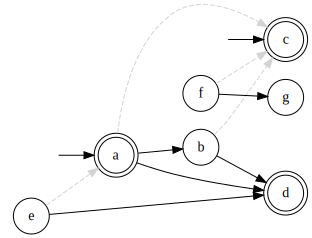

In [7]:
from dagger.query import Query

q = Query(dag).given(d=1).do(a=0, c=1)
q.plot()

In [8]:
# Query(dag).given(d=1).do(a=1, c=1).infer()

Next up: testing for independencies. 

In [9]:
import itertools as it 
import networkx as nx

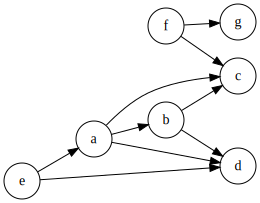

In [10]:
dag.plot()

In [11]:
dag.undirected_paths("e", "d")

[['e', 'a', 'd'], ['e', 'a', 'b', 'd'], ['e', 'a', 'c', 'b', 'd'], ['e', 'd']]

In [12]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(filename)s:%(funcName)s:%(lineno)d] %(levelname)s - %(message)s',
)

In [19]:
paths = list(dag.active_paths("e", "c", z=["b"]))

2019-02-17 16:21:26,514 [graph.py:directed_paths:125] DEBUG - found directed path: e -> a -> d <- b -> c
2019-02-17 16:21:26,515 [graph.py:directed_paths:125] DEBUG - found directed path: e -> a -> b -> c
2019-02-17 16:21:26,516 [graph.py:directed_paths:125] DEBUG - found directed path: e -> a -> c
2019-02-17 16:21:26,517 [graph.py:directed_paths:125] DEBUG - found directed path: e -> d <- a -> b -> c
2019-02-17 16:21:26,517 [graph.py:directed_paths:125] DEBUG - found directed path: e -> d <- a -> c
2019-02-17 16:21:26,518 [graph.py:directed_paths:125] DEBUG - found directed path: e -> d <- b <- a -> c
2019-02-17 16:21:26,519 [graph.py:directed_paths:125] DEBUG - found directed path: e -> d <- b -> c
2019-02-17 16:21:26,520 [graph.py:active_paths:139] DEBUG - now checking e -> a -> d <- given(b) -> c
2019-02-17 16:21:26,521 [graph.py:active_paths:139] DEBUG - now checking e -> a -> given(b) -> c
2019-02-17 16:21:26,522 [graph.py:active_paths:139] DEBUG - now checking e -> a -> c
2019-0

In [25]:
def check_node_blocking(arrow_before, arrow_after, name):
    given = "given" in name
    if (arrow_before == '<-') and (arrow_after == '->'):
        blocking = True if given else False
        logging.debug(f"checking: ... {arrow_before} {name} {arrow_after} ... type: `split` blocking: {blocking}")
    if (arrow_before == '->') and (arrow_after == '<-'):
        blocking = False if given else True
        logging.debug(f"checking: ... {arrow_before} {name} {arrow_after} ... type: `collider` blocking: {blocking}")
    if arrow_before == arrow_after:
        blocking =  True if given else False
        logging.debug(f"checking: ... {arrow_before} {name} {arrow_after} ... type: `chain` blocking: {blocking}")
    return blocking

def is_path_blocked(path):
    for idx, name in enumerate(path): 
        if idx in [0, len(path) - 1]:
            pass
        elif name in ['<-', '->']:
            pass
        else:
            arrow_before = path[idx - 1]
            arrow_after = path[idx + 1]
            blocking = check_node_blocking(arrow_before, arrow_after, name)
            if blocking:
                logging.info("found blocking node, can skip path")
                return True
    return False

def is_path_active(path):
    return not is_path_blocked(path)

[is_path_active(p) for p in paths]

2019-02-17 16:26:37,078 [<ipython-input-25-b4b53b3217e5>:check_node_blocking:11] DEBUG - checking: ... -> a -> ... type: `chain` blocking: False
2019-02-17 16:26:37,079 [<ipython-input-25-b4b53b3217e5>:check_node_blocking:8] DEBUG - checking: ... -> d <- ... type: `collider` blocking: True
2019-02-17 16:26:37,081 [<ipython-input-25-b4b53b3217e5>:is_path_blocked:25] INFO - found blocking node, can skip path
2019-02-17 16:26:37,082 [<ipython-input-25-b4b53b3217e5>:check_node_blocking:11] DEBUG - checking: ... -> a -> ... type: `chain` blocking: False
2019-02-17 16:26:37,083 [<ipython-input-25-b4b53b3217e5>:check_node_blocking:11] DEBUG - checking: ... -> given(b) -> ... type: `chain` blocking: True
2019-02-17 16:26:37,083 [<ipython-input-25-b4b53b3217e5>:is_path_blocked:25] INFO - found blocking node, can skip path
2019-02-17 16:26:37,084 [<ipython-input-25-b4b53b3217e5>:check_node_blocking:11] DEBUG - checking: ... -> a -> ... type: `chain` blocking: False
2019-02-17 16:26:37,085 [<ipyt

[False, False, True, False, False, False, False]